# ✅ Section 0: Set up dependencies and data

##Install dependencies

In [ ]:
# Uninstall CoLab version of pytorch and install detectron2 compatiable version
!pip uninstall torch torchvision torchtext torchaudio -y
!pip install torch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1

# Install pyyaml (version 5.1)
!pip install pyyaml==5.1

# Import torch
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

# Ensure detectron2 instalation matches pytorch version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

⚠️  **Attention:** After the installation of detectron2 in the above cell, **you may need to restart the runtime in Colab**. You can do this by selecting `Runtime > Restart Runtime` from the task bar, or by running the command `exit(0)`

Once detectron has been successfully installed, you can continue to the next cells.


## Set up Data

Download our dataset from https://drive.google.com/drive/folders/1QUk7AXNivhF9SRqwJA2lCihnp-nO8Juh?usp=sharing and store in a folder inside your Google Drive or point to this folder within your Google Drive. 

You will then need to specify the following paths: 
1. `REPO_LOC`: Google drive path to repo location
2. `DATASET_LOC`: Google drive path to dataset folder location 
3. `OUTPUT_LOC`: Google drive path to where you would like output to be generated

Note: To easily find the google drive file path, navigate to the `Files` tab of the side viewer and locate the location you saved the directory. By right clicking on the folder location, you can select `Copy path`. you can then paste these values to intialize the variables in the next cell.

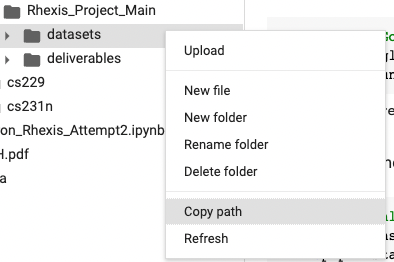



###⚠️ Specify your paths here and **DOUBLE CHECK!!!** ⚠️

NOTE FOR DEV TEAM: REPO and OUTPUT locations should NOT be in shared Google Drive folders. They should be private. (It is ok if Dataset Loc is a shared folder)

In [ ]:
REPO_LOC = "/content/drive/MyDrive/Trajectories/rhexis-trajectory"
DATASET_LOC = "/content/drive/MyDrive/Trajectories/datasets/Dataset_1000"

#Specify the shared checkpoints best folder
OUTPUT_LOC = "/content/drive/MyDrive/Trajectories/checkpoints"

assert REPO_LOC is not None, "Must specify a repository location"
assert DATASET_LOC is not None, "Must specify a dataset location"
assert OUTPUT_LOC is not None, "Must specify a output location"

In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

##Import required modules

In [ ]:
# Import detectron2
import detectron2
from detectron2.utils.logger import setup_logger

# Set up detectron2 logger
setup_logger()

# Import common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# Import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Import custom utility functions
import sys
sys.path.insert(0,f"{REPO_LOC}/Keypoint_Detection")
import utils

# Fine-tune COCO-pretrained R50-FPN Keypoint RCNN on dataset
from detectron2.engine import DefaultTrainer
from custom_trainer import CocoTrainer, CustomAugmentation, NoAugmentation
from configurations import load_cfg

In [ ]:
%load_ext autoreload
%autoreload 2

# 🏃 Section 1: Set-Up Training Run

Would you like to utilize [weights and biases](https://wandb.ai) in this run? Toggle the boolean below to control and log in when prompted

In [ ]:
use_wandb = True

In [ ]:
# Import wandb if use_wandb boolean is true
if use_wandb:
  !pip install wandb -qqq
  import wandb

  # Login to wandb
  wandb.login()

Would you like to continue training from a saved checkpoint or train from scratch?

In [ ]:
train_from_scratch = True

To resume training from last_checkpoint, Detectron2 needs `last_checkpoint` and the corresponding `.pth` file in `cfg.OUTPUT_DIR`

In the next cell, specify the name of the model checkpoint you would like to utilize.


Note: that when Detectron2 finishes a training run, it saves its final model as `model_final.pth`

In [ ]:
# To resume training from the final model OR the most recent checkpoint, 
# utilize the following:
# "model_final.pth"

# To resume training from a non-final model with a saved checkpoint:
# Specify the PREV_MODEL_CHECKPOINT as the name of the checkpoint file below

PREV_MODEL_CHECKPOINT = ""

🚨 Select (and **DOUBLE CHECK**) the **model architecture** 🏠 and **hyper-parameters** 🏡 you would like to utilize in this training run. 🚨

In [ ]:
# SELECT MODEL ARCHITECTURE ------------------------
# Resnet50: "keypoint_rcnn_R_50_FPN_3x"
# Resnet101: "keypoint_rcnn_R_101_FPN_3x"
# Resnext101: "keypoint_rcnn_X_101_32x8d_FPN_3x"

model_string = "keypoint_rcnn_X_101_32x8d_FPN_3x"
#--------------------------------------------------

# SELECT HYPER-PARAMETERS ------------------------
# MAX_ITER: How many iterations to train the model to
MAX_ITER = 10

# Base learning rate after linear warm-up and before any decay takes place
# default is 0.000025
LR = 0.005

# OKS_SIGMAS: list of length 2 containing decimal values for the 
# default is [0.03,0.03]
OKS_SIGMAS = [0.03, 0.03]
 
# SOLVER_STEPS: iterations where the learning rate decays by a factor of 0.1
# default is []
SOLVER_STEPS = []

# augmentation: Boolean, weather or not to conduct data augmentation
augmentation = True
#--------------------------------------------------

# 💾 Load and Visualize Data

In [ ]:
# Load in all datasets
utils.load_datasets_pipeline(DATASET_LOC)

In [ ]:
# utils.visualize_image_annotations('train', 3)

# 🤖 Section 3: Training the Detectron2 Model

Do not edit the cells below

In [ ]:
# Create the config object
cfg = load_cfg(model_string, MAX_ITER, LR, OKS_SIGMAS, SOLVER_STEPS)

# Create temporary save location
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Determine run name
from configurations import create_experiment_name
run_name = create_experiment_name(model_string, cfg.SOLVER.BASE_LR, cfg.TEST.KEYPOINT_OKS_SIGMAS, cfg.SOLVER.STEPS, augmentation)

#Create final output location
RUN_OUTPUT_LOC = os.path.join(OUTPUT_LOC, run_name)

print("Output of this run will save to:")
print(RUN_OUTPUT_LOC)

In [ ]:
# If a specific checkpoint is specified above, use it instead of the lastest
# checkpoint
if not train_from_scratch:
  final_model_path = ""
  if PREV_MODEL_CHECKPOINT:
    final_model_path = RUN_OUTPUT_LOC + "/" + PREV_MODEL_CHECKPOINT
    assert os.path.exists(final_model_path), f"{final_model_path} does not exist."

  else:
    # Attempt to utilize the latest checkpoint (if it exists)
    try:
      with open(RUN_OUTPUT_LOC + "/last_checkpoint", "r") as read_file:
        PREV_MODEL_CHECKPOINT = read_file.readline()
        print("Previous model path has been updated to last saved checkpoint")
        final_model_path = RUN_OUTPUT_LOC + "/" + PREV_MODEL_CHECKPOINT
    except FileNotFoundError:
      print("No file was found at: " + RUN_OUTPUT_LOC + "/last_checkpoint")
      # Remove last checkpoint so training starts over
      !rm $cfg.OUTPUT_DIR/last_checkpoint


  if final_model_path:
    !cp $final_model_path $cfg.OUTPUT_DIR
    !echo $PREV_MODEL_CHECKPOINT > $cfg.OUTPUT_DIR/last_checkpoint

    # Double check contents of cfg.OUTPUT_DIR and last_checkpoint
    !ls $cfg.OUTPUT_DIR
    !cat $cfg.OUTPUT_DIR/last_checkpoint
else:
  print("Training from scratch")
  !rm $cfg.OUTPUT_DIR/last_checkpoint

## Train the model



If WandB is active, save parameters to the config dict.

In [ ]:
if use_wandb:
  from datetime import datetime
  now = datetime.now()
  now_str = now.strftime("%m_%d_%H_%M_%S__")
  
  wandb.init(
    # Set the project where this run will be logged
    project="rhexis-trajectory-wandbtest",
    entity="rhexis-trajectory",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name="bbox_corrected_"+now_str+run_name,
    # Track hyperparameters and run metadata
    config={
      "learning_rate":cfg.SOLVER.BASE_LR,
      "OKS_SIGMAS":cfg.TEST.KEYPOINT_OKS_SIGMAS,
      "SOLVER_STEPS":cfg.SOLVER.STEPS,
      "data_augmentation": augmentation
    },
    sync_tensorboard=True)

### Run the following cell to train the model

Note: the following cell will take a long time to run

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
# Initialize trainer and train model
trainer = None
if augmentation:
  trainer = CustomAugmentation(cfg)
else:
  trainer = NoAugmentation(cfg)

# Run the trainer
trainer.resume_or_load()
trainer.train()

In [ ]:
if use_wandb:
  wandb.finish()

## 🎂 Congratulations! Your model has finished training! 🎂
Use the below cell to save the checkpoints. 

In [ ]:
from best_model_checkpoint import best_model_checkpoint

if not os.path.isdir(RUN_OUTPUT_LOC):
  os.makedirs(RUN_OUTPUT_LOC)

# Save the final checkpoint
try:
  last_checkpoint_pth = ""
  with open(f"{cfg.OUTPUT_DIR}/last_checkpoint", "r") as read_file:
    last_checkpoint_pth = read_file.readline().strip()
  print(last_checkpoint_pth)

  # Save the metrics to the output directory
  !cp $cfg.OUTPUT_DIR/metrics.json $RUN_OUTPUT_LOC

  # Save the last checkpoint to the output directory
  !cp $cfg.OUTPUT_DIR/last_checkpoint $RUN_OUTPUT_LOC
  !cp $cfg.OUTPUT_DIR/$last_checkpoint_pth $RUN_OUTPUT_LOC

except FileNotFoundError:
  print("No last_checkpoint file was found. The model may not have been run for long enough or was unable to save")


# Determine the best checkpoint and save the best checkpoint
try:
  bmc = best_model_checkpoint(cfg.OUTPUT_DIR)

  bmc = cfg.OUTPUT_DIR + os.sep + bmc
  !cp $bmc $RUN_OUTPUT_LOC

except FileNotFoundError:
  print("No best_checkpoint file was found.")


# Save cfg as YAML to checkpoint directory to help with inference later
with open(f"{cfg.OUTPUT_DIR}/config.yaml", 'w') as writer:
  writer.write(cfg.dump())
config_file = f"{cfg.OUTPUT_DIR}/config.yaml"
!cp $config_file $RUN_OUTPUT_LOC


# Double check contents of Checkpoints directory
!$RUN_OUTPUT_LOC
!ls $RUN_OUTPUT_LOC


# Prediction and Evaluation

### 🖼 Visualize predicted annotations on validation set

In [ ]:
from eval_model import RhexisVisualizer
RhexisVis = RhexisVisualizer(bmc, cfg, object_detection_threshold = 0.98)

In [ ]:
image_set = RhexisVis.randomly_sample_images_from_set("test",2)
RhexisVis.detectron2_visualizer(sampled_list = image_set)

In [ ]:
RhexisVis.compare_labels(sampled_list = image_set)

### 📹 Generate annotated test video using model predictions

In [ ]:
# Initialize parameters for generating video annotations

# --config-file
# Save cfg as config.yaml in cfg.OUTPUT_DIR
with open(f"{cfg.OUTPUT_DIR}/config.yaml", 'w') as writer:
  writer.write(cfg.dump())
config_file = f"{cfg.OUTPUT_DIR}/config.yaml"

# --video-input
# test video = DATASET_LOC/test_video_Cataract_Coach7_5s.mp4
test_video = DATASET_LOC + '/test_video_CataractCoach7_5s.mp4'
print("test video: ", test_video)

# --output
# Save to output to RUN_OUTPUT_LOC for now
video_output = RUN_OUTPUT_LOC + "/CataractCoach7_5s_output.mp4"
print("video output: ", video_output)

# --opts MODEL.WEIGHTS
best_model_weights = bmc

In [ ]:
# Generate annotated test video
# Note: this is currently BROKEN for x264 codec but ok for mp4. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.

!python $REPO_LOC/Keypoint_Detection/generate_annotated_mp4.py --config-file $config_file --video-input $test_video --confidence-threshold 0.98 --output $video_output --opts MODEL.WEIGHTS $best_model_weights